In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import Estimate
import figure 
from EconModel import cpptools
import pickle

from LimitedCommitmentModel import LimitedCommitmentModelClass

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)


plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

SAVE = False

# c++ settings

do_compile = True
threads = 20
T = 20
#cpptools.setup_nlopt(folder='cppfuncs/', do_print = True) #install nlopt


# Load the model

In [2]:
name = 'model_LC'
model_name = "model_LC"
do_distr_yerror = "norm"
do_yerror = 2
name_error = "norm2std_Yerror_love"
N = 5000
#name_error = "uni2std_Yerror"

specs = {}
#specs.update({f'test2':{'latexname':'limited', 'par':{ 'T':T, 'num_K': 5, 'num_A': 10 ,  'do_HK': False, 'threads':threads,'bargaining':0}}})


specs.update({f'model_LC':{'latexname':'limited', 'par':{ 'T':T, 'do_HK': False, 'simN': N,  'threads':threads,'bargaining':1}}})
#specs.update({f'model_NC':{'latexname':'limited', 'par':{ 'T':T, 'do_HK': False, 'simN': N,  'threads':threads,'bargaining':2}}})
#specs.update({f'model_FC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'simN': N,  'threads':threads,'bargaining':0}}})

# solve different models
models = {}
for m,(name,spec) in enumerate(specs.items()):
    
    # setup model
    model = LimitedCommitmentModelClass(name=name,par=spec['par'])
    model.spec = spec

    compile_now = True if do_compile & (m==0) else False
    model.link_to_cpp(force_compile=compile_now)
    

# setup model
#model = LimitedCommitmentModelClass(name=name)    
#model.link_to_cpp(force_compile=True)


#load par and sol
pickle_file = f'output/{name}_sol.pickle'

with open(pickle_file, 'rb') as f:
    model.sol = pickle.load(f)

pickle_file = f'output/{name}_par.pickle'

with open(pickle_file, 'rb') as f:
    model.par = pickle.load(f)
    model.par.simN = N

In [ ]:
#Do 1 time estimate
data = Estimate.create_data(model,start_p = 2, end_p = model.par.T-2)
data = Estimate.create_variable(data, model.par)
data = Estimate.aux_est(data,model.par)

_, wald_FC_w , wald_NC_w, wald_FC_noW_w,  wald_NC_noW_w, _ = Estimate.main_est(data,gender= "w", do_estimate_wage = "est_omega", print_reg = True, shadow_value_simple=4, do_control_love = False)
            

c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[delta_log_l] = data[log_name_l]-data[log_name_l2]
c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:193: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[delta_log_l2] = data[log_name_l2]-data[log_name_l3]
c:\Users\czk481\project\LimitedCommitmentTest-1\Estimate.py:191: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

                            OLS Regression Results                            
Dep. Variable:                    y_w   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.524
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           6.76e-30
Time:                        12:12:50   Log-Likelihood:                -410.92
No. Observations:                2449   AIC:                             1450.
Df Residuals:                    2135   BIC:                             3272.
Df Model:                         313                                         
Covariance Type:              cluster                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0838    

In [ ]:
#run regression S times

model.sim.init_love[:] = 0.2
model.sim.init_A[:] = 2.0
list_wage = ["est_omega","true_omega", "wage"]
list_love = [True, False]
#list_wage = ["est_omega","true_omega",]
#list_love = [True,]
#name_est = "No_love_est_omega"

np.random.seed(model.par.seed)

no_sim = 100
wald_FC_w_pval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )
wald_NC_w_pval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )
wald_FC_m_pval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )
wald_NC_m_pval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )


wald_FC_noW_w_pval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) ) 
wald_NC_noW_w_pval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )
wald_FC_noW_m_pval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )
wald_NC_noW_m_pval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )


wald_FC_w_fval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) ) 
wald_NC_w_fval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )
wald_FC_m_fval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )
wald_NC_m_fval = np.nan + np.ones((4,len(list_wage),len(list_love),no_sim) )



wald_FC_w_negative = np.nan + np.ones((4,len(list_wage),len(list_love))) 
wald_NC_w_negative = np.nan + np.ones((4,len(list_wage),len(list_love)))
wald_FC_m_negative = np.nan + np.ones((4,len(list_wage),len(list_love)))
wald_NC_m_negative = np.nan + np.ones((4,len(list_wage),len(list_love)))


wald_FC_w_noW_negative = np.nan + np.ones((4,len(list_wage),len(list_love))) 
wald_NC_w_noW_negative = np.nan + np.ones((4,len(list_wage),len(list_love)))
wald_FC_m_noW_negative = np.nan + np.ones((4,len(list_wage),len(list_love)))
wald_NC_m_noW_negative = np.nan + np.ones((4,len(list_wage),len(list_love)))



N_w= np.nan + np.ones(no_sim) 
N_m= np.nan + np.ones(no_sim) 
#loop over shadow values
#for j in range(4):
#    j = j +1
for j in [1,2,3,4]:

    #do_wage = "est_omega"
    for ik, do_wage in enumerate(list_wage):
    # # Her skal jeg have 3 strings
        for im, do_love in enumerate(list_love):
        #her skal jeg evt loope over love
        
            for i in range(no_sim):
                data = Estimate.create_data(model,start_p = 2, end_p = model.par.T-2)
                data = Estimate.create_variable(data, model.par)
                #if k:
                data = Estimate.aux_est(data,model.par)
                _, wald_FC_w , wald_NC_w, wald_FC_noW_w,  wald_NC_noW_w, N_w[i] = Estimate.main_est(data,gender= "w", do_estimate_wage = do_wage, print_reg = False, shadow_value_simple=j, do_control_love = do_love)
                _, wald_FC_m , wald_NC_m, wald_FC_noW_m,  wald_NC_noW_m, N_m[i] = Estimate.main_est(data,gender= "m", do_estimate_wage = do_wage, print_reg = False, shadow_value_simple=j, do_control_love = do_love)
        
                wald_FC_w_pval[j-1, ik, im, i] = wald_FC_w.pvalue
                wald_FC_m_pval[j-1, ik, im, i] = wald_FC_m.pvalue
                wald_NC_w_pval[j-1, ik, im, i] = wald_NC_w.pvalue
                wald_NC_m_pval[j-1, ik, im, i] = wald_NC_m.pvalue

                wald_FC_noW_w_pval[j-1, ik, im, i] = wald_FC_noW_w.pvalue
                wald_FC_noW_m_pval[j-1, ik, im, i] = wald_FC_noW_m.pvalue
                wald_NC_noW_w_pval[j-1, ik, im, i] = wald_NC_noW_w.pvalue
                wald_NC_noW_m_pval[j-1, ik, im, i] = wald_NC_noW_m.pvalue
                    
                    
            #note True = 1, false = 0
            wald_FC_w_negative[j-1,ik,im] = np.sum(wald_FC_w_pval[j-1,ik,im,:]< 0.05)/no_sim
            wald_FC_m_negative[j-1,ik,im] = np.sum(wald_FC_m_pval[j-1,ik,im:]< 0.05)/no_sim
            wald_NC_w_negative[j-1,ik,im] = np.sum(wald_NC_w_pval[j-1,ik,im:]< 0.05)/no_sim
            wald_NC_m_negative[j-1,ik,im] = np.sum(wald_NC_m_pval[j-1,ik,im,:]< 0.05)/no_sim

            wald_FC_w_noW_negative[j-1,ik,im] = np.sum(wald_FC_noW_w_pval[j-1,ik,im,:]< 0.05)/no_sim
            wald_FC_m_noW_negative[j-1,ik,im] = np.sum(wald_FC_noW_m_pval[j-1,ik,im,:]< 0.05)/no_sim
            wald_NC_w_noW_negative[j-1,ik,im] = np.sum(wald_NC_noW_w_pval[j-1,ik,im,:]< 0.05)/no_sim
            wald_NC_m_noW_negative[j-1,ik,im] = np.sum(wald_NC_noW_m_pval[j-1,ik,im,:]< 0.05)/no_sim



In [8]:
#SAVE PICKLE

pickle_file = f'output/TRUE{name}_w_N{model.par.simN}_S{no_sim}_{do_distr_yerror}{do_yerror}_testFC.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(wald_FC_w_pval,f)
pickle_file = f'output/TRUE{name}_m_N{model.par.simN}_S{no_sim}_{do_distr_yerror}{do_yerror}_testFC.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(wald_FC_m_pval,f)
pickle_file = f'output/TRUE{name}_w_N{model.par.simN}_S{no_sim}_{do_distr_yerror}{do_yerror}_testNC.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(wald_NC_w_pval,f)
pickle_file = f'output/TRUE{name}_m_N{model.par.simN}_S{no_sim}_{do_distr_yerror}{do_yerror}_testNC.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(wald_NC_m_pval,f)


In [ ]:
print(wald_NC_w_negative)
print(wald_NC_m_negative)
print(wald_NC_w_noW_negative)
print(wald_NC_m_noW_negative)


In [10]:
def fig_density(NC_simple, NC_complex, FC_simple, FC_complex, gender, model_True, save_fig, models ):
    hist, bins = np.histogram(NC_simple, range = [0, 1], bins =20, density = True)
    hist = hist/20

    cumhist1 = np.cumsum(hist)


    hist, bins = np.histogram(NC_complex, range = [0, 1], bins =20, density = True)
    hist = hist/20
    cumhist2 = np.cumsum(hist)


    hist, bins = np.histogram(FC_simple, range = [0, 1], bins =20, density = True)
    hist = hist/20
    cumhist3 = np.cumsum(hist)


    hist, bins = np.histogram(FC_complex, range = [0, 1], bins =20, density = True)
    hist = hist/20
    cumhist4 = np.cumsum(hist)


    plt.plot(bins[1:], cumhist1, label="NC, simpel shadow")
    plt.plot(bins[1:], cumhist2, label="NC, complex shadow")
    plt.plot(bins[1:], cumhist3, label="FC, simpel shadow")
    plt.plot(bins[1:], cumhist4, label="FC, complex shadow")
    plt.plot(np.linspace(0.0,1.0, 10), np.linspace(0.0,1.0,10), label = "45 degree", color = 'red')
    plt.xlabel(f'P value for $H_0$')
    #plt.axvline(x= 0.05, color = 'red')
    plt.ylabel('Cumulative Density')
    plt.legend()
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.savefig(f'output/Wald__TRUE{model_True}_{gender}_N{models.par.simN}_{save_fig}.png')
    plt.show()


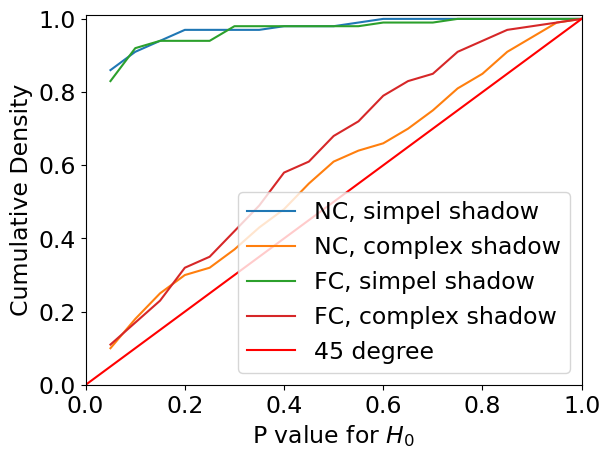

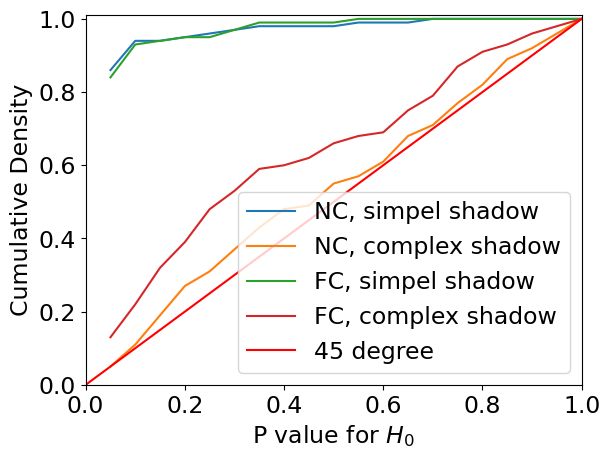

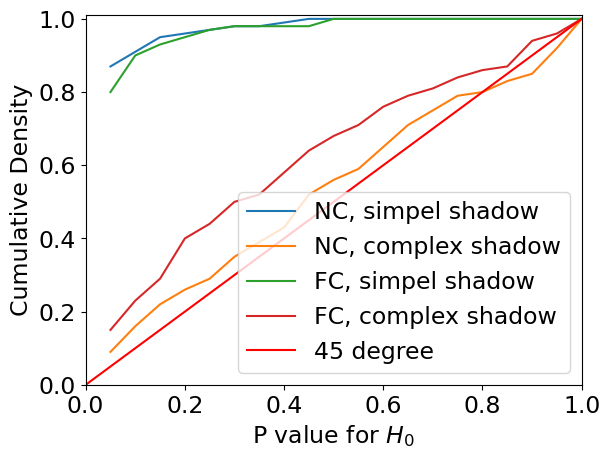

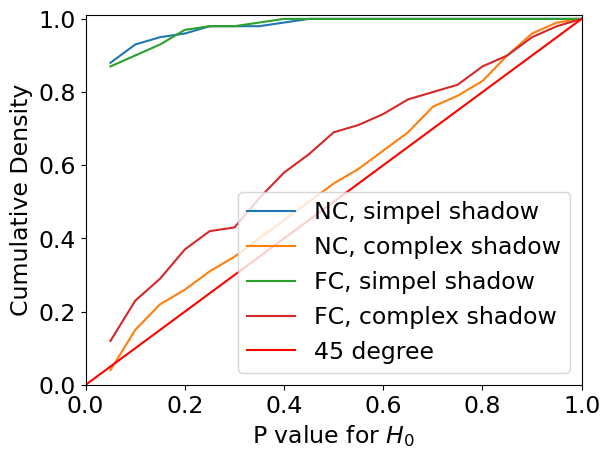

In [13]:
# GET FIGURE
ik = 0
im = 0 #no love
fig_density(wald_NC_m_pval[0,ik,im], wald_NC_m_pval[3,ik,im],wald_FC_m_pval[0,ik,im],wald_FC_m_pval[3,ik,im], "man", model_name, f'{name_error}_no_love', model)
fig_density(wald_NC_w_pval[0,ik,im], wald_NC_w_pval[3,ik,im],wald_FC_w_pval[0,ik,im],wald_FC_w_pval[3,ik,im], "woman", model_name, f'{name_error}_no_love', model)

ik = 1
fig_density(wald_NC_m_pval[0,ik,im], wald_NC_m_pval[3,ik,im],wald_FC_m_pval[0,ik,im],wald_FC_m_pval[3,ik,im], "man", model_name, f'{name_error}_wage_no_love', model)
fig_density(wald_NC_w_pval[0,ik,im], wald_NC_w_pval[3,ik,im],wald_FC_w_pval[0,ik,im],wald_FC_w_pval[3,ik,im], "woman", model_name, f'{name_error}_wage_no_love', model)

#fig_density(wald_NC_m_pval[0,ik], wald_NC_m_pval[2,ik],wald_FC_m_pval[0,ik],wald_FC_m_pval[2,ik], "man", model_name, "small_error")
#fig_density(wald_NC_w_pval[0,ik], wald_NC_w_pval[2,ik],wald_FC_w_pval[0,ik],wald_FC_w_pval[2,ik], "woman", model_name, "small_error")

In [6]:

stop

[[[0.86 0.91]
  [0.88 0.88]
  [0.82 0.84]]

 [[0.8  0.77]
  [0.78 0.84]
  [0.84 0.78]]

 [[0.84 0.89]
  [0.85 0.89]
  [0.87 0.88]]

 [[0.05 0.07]
  [0.04 0.06]
  [0.02 0.07]]]
[[[0.86 0.91]
  [0.87 0.9 ]
  [0.91 0.89]]

 [[0.81 0.9 ]
  [0.76 0.79]
  [0.83 0.83]]

 [[0.86 0.79]
  [0.84 0.9 ]
  [0.81 0.9 ]]

 [[0.1  0.07]
  [0.09 0.05]
  [0.06 0.05]]]
[[[0.91 0.96]
  [0.92 0.93]
  [0.89 0.88]]

 [[0.83 0.88]
  [0.88 0.93]
  [0.87 0.88]]

 [[0.91 0.94]
  [0.89 0.94]
  [0.94 0.95]]

 [[0.04 0.04]
  [0.06 0.07]
  [0.05 0.04]]]
[[[0.93 0.98]
  [0.91 0.97]
  [0.94 0.91]]

 [[0.89 0.92]
  [0.87 0.85]
  [0.89 0.87]]

 [[0.89 0.88]
  [0.94 0.91]
  [0.87 0.92]]

 [[0.09 0.04]
  [0.11 0.06]
  [0.06 0.04]]]


In [16]:
#LOAD PICKLE (SEPERETAE FILE )

pickle_file = f'output/TRUE{name}_w_N{model.par.simN}_S{no_sim}_{do_distr_yerror}{do_yerror}_testFC.pickle'


with open(pickle_file, 'rb') as f:
    FC_woman = pickle.load(f)
print(FC_woman)

(4, 3, 2, 100)


In [ ]:
#data[['wage_m','wage_w']].describe()


#LAV FORDELING MED MAIN OG NONP , og med MAIN og xx

#wage_w      =  np.exp(model.par.wage_const_w +model.par.wage_K_w*model.sim.Kw)   
#y_w         =  wage_w*model.sim.labor_w
#wage_m      =  np.exp(model.par.wage_const_m+model.par.wage_K_m* model.sim.Km)
#y_m         =  wage_m*model.sim.labor_m

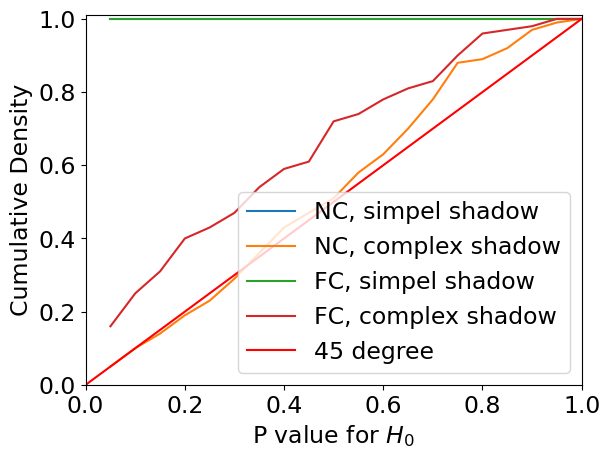

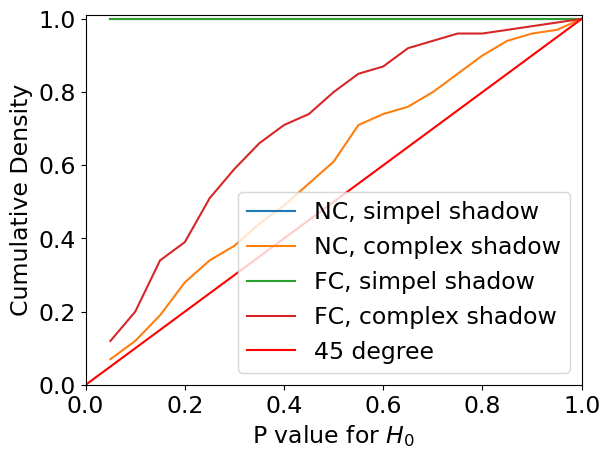

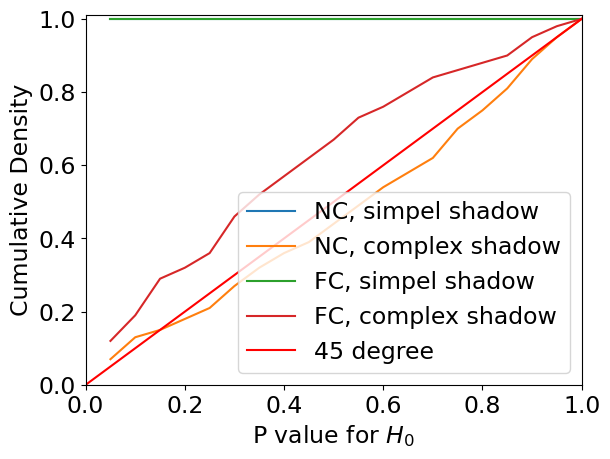

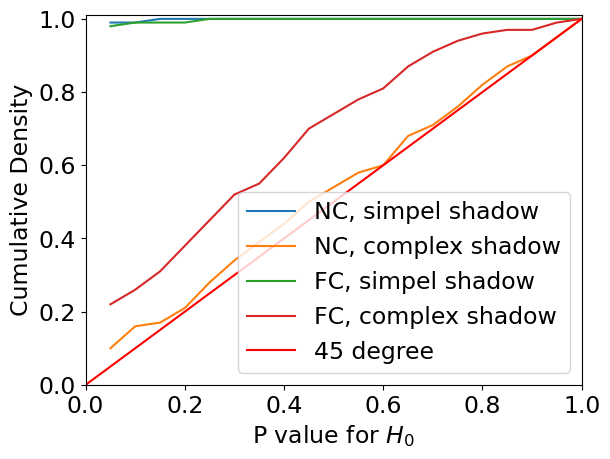

In [ ]:
stop

In [ ]:

#load par and sol
pickle_file = f'output/{name}_sol.pickle'

with open(pickle_file, 'rb') as f:
    model.sol = pickle.load(f)


NameError: name 'stop' is not defined

In [ ]:
#TEST 
data = Estimate.create_data(model,start_p = 2, end_p = model.par.T-2)
print(np.mean(data['hours_w'])-np.mean(data['hours_m']))
print(np.mean(data['wage_w'])-np.mean(data['wage_m']))
print(np.mean(data['earnings_w'])-np.mean(data['earnings_m']))
print(np.mean(data['BMI_w'])-np.mean(data['BMI_m']))
data = Estimate.create_variable(data, model.par)


In [ ]:
#data[['wage_w_orig','wage_m_orig', 'hours_w_orig','hours_m_orig','wealth_orig', 'wage_w','wage_m', 'hours_w','hours_m','wealth', 'cons']].describe()

#wage_w_orig = np.exp(model.par.wage_const_w +model.par.wage_K_w*model.sim.Kw) 
#wage_m_orig = np.exp(model.par.wage_const_m +model.par.wage_K_m*model.sim.Km) 

#std = np.std(wage_w_orig)
#std2 = np.std(wage_m_orig)
#print(std)
#print(std2)
iK= 6
iZ = 0

test = np.allclose(model.sol.Vw_single, model.sol.Vm_single)
print(f'V_single {test}')
test = np.allclose(model.sol.labor_w_single , model.sol.labor_m_single)
print(f'labor_single {test}')
test = np.allclose(model.sol.cons_w_single , model.sol.cons_m_single)
print(f'cons_single {test}')
test = np.allclose(model.sol.Vw_couple[:, iZ, iZ, 5, :, :, iK, iK], model.sol.Vm_couple[:, iZ, iZ, 5, :, :, iK, iK], atol = 0.1)
print(f'V_couple {test}')
test = np.allclose(model.sol.labor_w_couple[:, iZ, iZ, 5, :, :, iK, iK] , model.sol.labor_m_couple[:, iZ, iZ, 5, :, :, iK, iK], atol = 0.1 )
print(f'labor couple {test}')
test = np.allclose(model.sol.cons_w_couple[:, iZ, iZ, 5, :, :, iK, iK], model.sol.cons_m_couple[:, iZ, iZ, 5, :, :, iK, iK], atol = 0.1)
print(f'C couple {test}')
test = np.allclose(model.sol.Vw_remain_couple[:,iZ, iZ, 5, :, :, iK, iK], model.sol.Vm_remain_couple[:, iZ, iZ,  5, :, :, iK, iK], atol = 0.1)
print(f'V_remain {test}')
test = np.allclose(model.sol.labor_w_remain_couple[:, iZ, iZ, 5, :, :, iK, iK] , model.sol.labor_m_remain_couple[:, iZ, iZ, 5, :, :, iK, iK], atol = 0.1)
print(f'labor_remain {test}')
test = np.allclose(model.sol.cons_w_remain_couple[:, iZ, iZ, 5, :, :, iK, iK], model.sol.cons_m_remain_couple[:, iZ, iZ, 5, :, :, iK, iK], atol = 0.1)
print(f'cons_remain {test}')
test = np.isclose(model.sol.labor_w_remain_couple[:, iZ, iZ, 5, :, :, iK, iK] , model.sol.labor_m_remain_couple[:,iZ, iZ,  5, :, :, iK, iK], atol = 0.1)
ind = np.where(np.logical_not(test))
print(ind) #all difference is where wealth high


ind = np.where(np.logical_not(test))
print(ind)
np.random.seed(model.par.seed)
model.simulate()

In [ ]:
print(np.mean(model.sim.labor_w )-np.mean(model.sim.labor_m ))
print(np.mean(model.sim.Kw )-np.mean(model.sim.Km ))
print(np.mean(model.sim.Zw )-np.mean(model.sim.Zm ))
print(np.mean(model.sim.cons_w )-np.mean(model.sim.cons_m ))
print(np.mean(model.sim.exp_w )-np.mean(model.sim.exp_m )) 
print(np.mean(model.sim.Aw )-np.mean(model.sim.Am )) 

In [ ]:
print(np.mean(data['y_w'])-np.mean(data['y_m']))
print(np.mean(data['log_earnings_w'])-np.mean(data['log_earnings_m']))
print(np.mean(data['delta_log_wage_w'])-np.mean(data['delta_log_wage_m']))
print(np.mean(data['omega_res_w'])-np.mean(data['omega_res_m']))
print(np.mean(data['delta_omega_w'])-np.mean(data['delta_omega_m']))
print(np.mean(data['control_part_inc_w'])-np.mean(data['control_part_inc_m']))
print(np.mean(data['delta_log_BMI_w'])-np.mean(data['delta_log_BMI_m']))


print(np.mean(data['log_earnings_w_l'])-np.mean(data['log_earnings_m_l']))
print(np.mean(data['omega_res_w_l'])-np.mean(data['omega_res_m_l']))
print(np.mean(data['delta_omega_w_l'])-np.mean(data['delta_omega_m_l']))
print(np.mean(data['delta_log_BMI_w_l'])-np.mean(data['delta_log_BMI_m_l']))


print(np.mean(data['omega_res_w_l2'])-np.mean(data['omega_res_m_l2']))
print(np.mean(data['delta_omega_w_l2'])-np.mean(data['delta_omega_m_l2']))
print(np.mean(data['delta_log_BMI_w_l2'])-np.mean(data['delta_log_BMI_m_l2']))


C:\Users\czk481\AppData\Local\Temp\2\ipykernel_7940\2539133232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Shadow_value[i] = pd.qcut(data[i], 10, labels = False, duplicates='raise')
C:\Users\czk481\AppData\Local\Temp\2\ipykernel_7940\2539133232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Shadow_value[i] = pd.qcut(data[i], 10, labels = False, duplicates='raise')
C:\Users\czk481\AppData\Local\Temp\2\ipykernel_7940\2539133232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10403 entries, 0 to 10402
Columns: 320 entries, earnings_w_m_0_4 to wealth_n_l_9_9
dtypes: float64(320)
memory usage: 25.4 MB


inc_share_n_l_9_3       3.0
wealth_n_l_7_4          3.0
inc_share_n_l_1_6       3.0
earnings_w_m_2_1        3.0
earnings_w_m_l_1_3      4.0
                      ...  
wealth_n_l_6_6        545.0
wealth_n_l_0_0        582.0
wealth_n_l_7_7        609.0
wealth_n_l_8_8        682.0
wealth_n_l_9_9        896.0
Length: 320, dtype: float64